In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 10)
(10000, 10)


In [18]:
# 1, 5, 6을 가진 training set, testing set

train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6))
test_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
            (np.argmax(mnist.test.labels, 1) == 5) | \
            (np.argmax(mnist.test.labels, 1) == 6))

train_imgs   = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
test_imgs    = mnist.test.images[test_idx]
test_labels  = mnist.test.labels[test_idx]
n_train      = train_imgs.shape[0]
n_test       = test_imgs.shape[0]

print ("Packages loaded")
print ("The number of trainimgs : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testimgs : {}, shape : {}".format(n_test, test_imgs.shape))

Packages loaded
The number of trainimgs : 16583, shape : (16583, 784)
The number of testimgs : 2985, shape : (2985, 784)


In [24]:
# Shape of input and latent variable
n_input = 28*28

# Encoder shape
n_encoder1 = 500
n_encoder2 = 300

n_latent = 2 
#  !!!!!어떻게 결정할 것인가 
# 복구성능이 나올때까지 node수를 키워야함. 
# 그 전까지는 key information을 가지기에 부족한 차원임.

# Decoder shape
n_decoder1 = 300
n_decoder2 = 500

In [25]:
weights = {
    'encoder1' : tf.Variable(tf.random_normal([n_input, n_encoder1], stddev=0.1)),
    'encoder2' : tf.Variable(tf.random_normal([n_encoder1, n_encoder2], stddev=0.1)),
    'latent' : tf.Variable(tf.random_normal([n_encoder2, n_latent], stddev=0.1)),
    'decoder1' : tf.Variable(tf.random_normal([n_latent, n_decoder1], stddev=0.1)),
    'decoder2' : tf.Variable(tf.random_normal([n_decoder1, n_decoder2], stddev=0.1)),
    'reconst' : tf.Variable(tf.random_normal([n_decoder2, n_input], stddev=0.1))
}

biases = {
    'encoder1' : tf.Variable(tf.random_normal([n_encoder1], stddev=0.1)),
    'encoder2' : tf.Variable(tf.random_normal([n_encoder2], stddev=0.1)),
    'latent' : tf.Variable(tf.random_normal([n_latent], stddev=0.1)),
    'decoder1' : tf.Variable(tf.random_normal([n_decoder1], stddev=0.1)),
    'decoder2' : tf.Variable(tf.random_normal([n_decoder2], stddev=0.1)),
    'reconst' : tf.Variable(tf.random_normal([n_input], stddev=0.1))
}

x = tf.placeholder(tf.float32, [None, n_input])

In [20]:
def encoder(x, weights, biases):
    # (batch size X 784) * (784 X 500)
    encoder1 = tf.add(tf.matmul(x, weights['encoder1']), biases['encoder1'])
    encoder1 = tf.nn.tanh(encoder1)
    
    # (batch size X 500) * (500 X 300)
    encoder2 = tf.add(tf.matmul(encoder1, weights['encoder2']), biases['encoder2'])
    encoder2 = tf.nn.tanh(encoder2)
    
    # (batch size X 300) * (300 X 2)
    latent = tf.add(tf.matmul(encoder2, weights['latent']), biases['latent'])

    return latent

In [21]:
def decoder(latent, weights, biases):
    # (batch size X 2) * (2 X 300)
    decoder1 = tf.add(tf.matmul(latent, weights['decoder1']), biases['decoder1'])
    decoder1 = tf.nn.tanh(decoder1)
    
    # (batch size X 300) * (300 X 500)
    decoder2 = tf.add(tf.matmul(decoder1, weights['decoder2']), biases['decoder2'])
    decoder2 = tf.nn.tanh(decoder2)
    
    # (batch size X 500) * (500 X 784)
    reconst = tf.add(tf.matmul(decoder2, weights['reconst']), biases['reconst'])
   
    return reconst

In [26]:
LR = 0.0001

latent = encoder(x, weights, biases)
reconst = decoder(latent, weights, biases)
loss = tf.square(tf.subtract(x, reconst))  # Regression처럼
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

In [27]:
n_batch = 50
n_iter = 2500
n_prt = 250

In [29]:
def batch_maker(batch_size, img, label):
    img_len = len(img)
    # img의 길이까지 batch_size 갯수만큼 랜덤한 자연수 생성 
    random_idx = np.random.randint(img_len, size = batch_size)
    return img[random_idx], label[random_idx]

# [1, 5, 6] 만 쓰기 위해서

In [36]:
# Run initialize
# config = tf.ConfigProto(allow_soft_placement=True)  
# GPU Allocating policy
# sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

print(train_imgs.shape)
print(len(train_labels))
# Training cycle
for epoch in range(n_iter):
    train_x, train_y = batch_maker(n_batch, train_imgs, train_labels)
    sess.run(optm, feed_dict={x : train_x})  # output이 없다
    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

(16583, 784)
16583
Iter : 0
Cost : 0.5266731381416321
(50, 784) (50, 10)
Iter : 250
Cost : 0.05515283718705177
(50, 784) (50, 10)
Iter : 500
Cost : 0.04509667307138443
(50, 784) (50, 10)
Iter : 750
Cost : 0.04341128095984459
(50, 784) (50, 10)
Iter : 1000
Cost : 0.040387291461229324
(50, 784) (50, 10)
Iter : 1250
Cost : 0.04651251435279846
(50, 784) (50, 10)
Iter : 1500
Cost : 0.04023829847574234
(50, 784) (50, 10)
Iter : 1750
Cost : 0.037619106471538544
(50, 784) (50, 10)
Iter : 2000
Cost : 0.039222631603479385
(50, 784) (50, 10)
Iter : 2250
Cost : 0.03979413956403732
(50, 784) (50, 10)


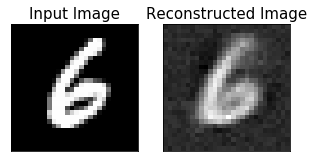

In [12]:
# testing batch 1개
test_x, test_y = batch_maker(1, test_imgs, test_labels) 
# testing input을 reconstruction 한 것 
x_reconst = sess.run(reconst, feed_dict={x : test_x}) 

fig = plt.figure(figsize=(5, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(test_x.reshape(28, 28), 'gray')
ax1.set_title('Input Image', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(x_reconst.reshape(28, 28), 'gray')
ax2.set_title('Reconstructed Image', fontsize=15)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

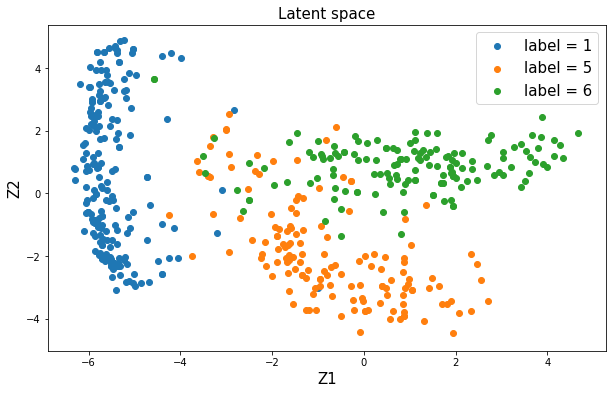

In [40]:
# 여기서부터가 중요 !!!!!
# latent를 비교 

test_x, test_y = batch_maker(500, test_imgs, test_labels)
test_y = np.argmax(test_y, axis=1) # 1열로 줄세움 
test_latent = sess.run(latent, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.scatter(test_latent[test_y == 1, 0], test_latent[test_y == 1, 1], label = 'label = 1')
plt.scatter(test_latent[test_y == 5, 0], test_latent[test_y == 5, 1], label = 'label = 5')
plt.scatter(test_latent[test_y == 6, 0], test_latent[test_y == 6, 1], label = 'label = 6')
plt.title('Latent space', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.legend(fontsize = 15)
plt.show()

# 784차원이 아니라 2차원정도면 구분이 되는 정도로 가져왔다.

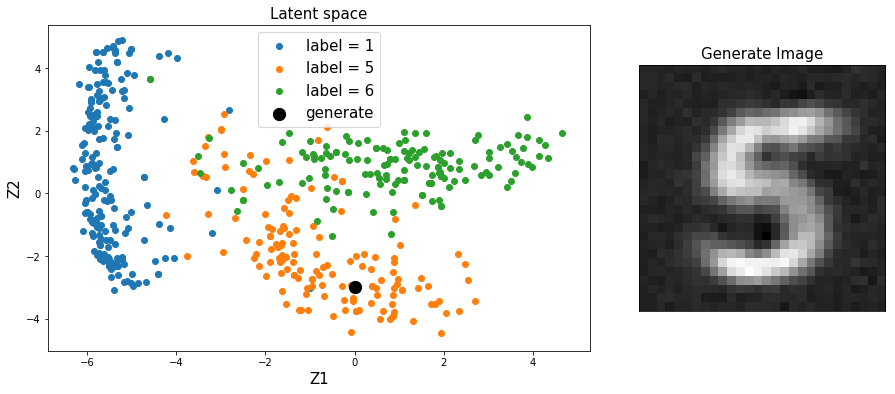

In [45]:
generate_data = np.array([[0, -3]])

fig = plt.figure(figsize=(15,6))
ax = plt.subplot2grid((1,3), (0,0), colspan=2)
ax.scatter(test_latent[test_y == 1,0], test_latent[test_y == 1,1], label = 'label = 1')
ax.scatter(test_latent[test_y == 5,0], test_latent[test_y == 5,1], label = 'label = 5')
ax.scatter(test_latent[test_y == 6,0], test_latent[test_y == 6,1], label = 'label = 6')
ax.scatter(generate_data[:,0], generate_data[:,1], label = 'generate', s = 150, c = 'k', marker = 'o')
ax.set_title('Latent space', fontsize=15)
ax.set_xlabel('Z1', fontsize=15)
ax.set_ylabel('Z2', fontsize=15)
ax.legend(fontsize = 15)

latent_input = tf.placeholder(tf.float32, [None, n_latent]) #n_latent =  2
reconst = decoder(latent_input, weights, biases)
generate_x = sess.run(reconst, feed_dict={latent_input : generate_data})
# 임의의 2차원의 점을 decoder에 돌려놓으니 예상한 클래스에 있는 수를 얻는다.

ax = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax.imshow(generate_x.reshape(28, 28), 'gray')
ax.set_title('Generate Image', fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# 생성해냈다 !!! 놀라운 순간.

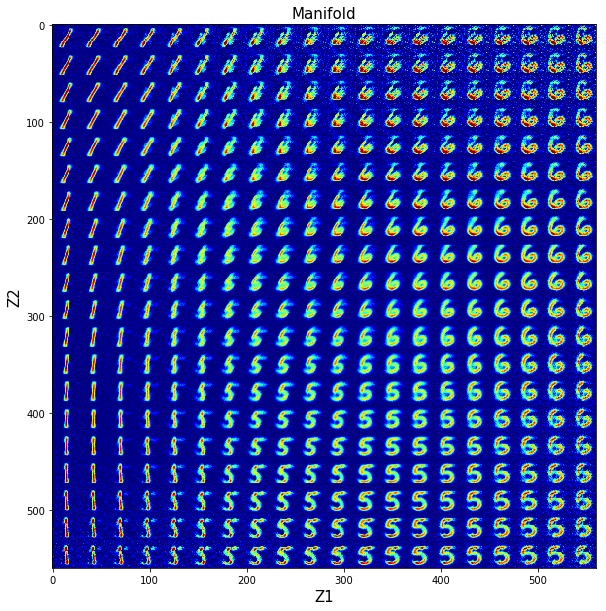

In [53]:
# Initialize canvas
# 2차원의 그래프를 격자로 나눠 생성해보면 어떤 게 나올까 
nx = ny = 20
x_values = np.linspace(-6, 4, nx)  # 2차원 latent data x축 범위
y_values = np.linspace(-4, 5, ny)
canvas = np.empty((28*ny, 28*nx)) # (28x20) x (28x20)


# Define placeholder
latent_input = tf.placeholder(tf.float32, [None, n_latent]) # [ ,2]
reconst = decoder(latent_input, weights, biases)

for i, yi in enumerate(y_values):  # i 는 반복횟수, yi에 값이 들어감
        for j, xi in enumerate(x_values):
            latent_ = np.array([[xi, yi]]) # 임의의 [xi, yi]가 들어가면 
            reconst_ = sess.run(reconst, feed_dict={latent_input : latent_})
            #어떤 위치에 복원할 것인가.
            canvas[(nx-i-1)*28:(nx-i)*28,j*28:(j+1)*28] = reconst_.reshape(28, 28)

# canvas[19*28:20*28,0:28]   i=0, j=0   x0=-6, y0=-4
# canvas[19*28:20*28,28:56]   i=0, j=1 x0=-5.47, y0=-4 
# canvas[19*28:20*28,56:28*3] ->>>> 맨 아래 x축을 따라서 그려짐             
            
plt.figure(figsize=(10, 10))
plt.imshow(canvas, clim=(0, 1), cmap=plt.cm.jet)
plt.title('Manifold', fontsize=15)
# plt.xticks([])
plt.xlabel('Z1', fontsize=15)
# plt.yticks([])
plt.ylabel('Z2', fontsize=15)
plt.show()